# Data Pre-processing: Audio

In this recitation, we will introduce a few concepts in data preprocessing for audio (speech) that are relevant to the course.

Here is a great reference to read more about speech pre-processing [Speech Processing Book](https://speechprocessingbook.aalto.fi/index.html)

Optional readings:<br>
[article on MFCCs](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html) <br>

[SpecAugment paper](https://www.isca-archive.org/interspeech_2019/park19e_interspeech.pdf) <br>

[Torch Audio Transforms docs](https://pytorch.org/audio/stable/transforms.html) <br>

Credit to Katerina (IDL S24 TA) from whom some material was borrowed

## Introduction

### Motivation

Sound signals are pressure variations that are often represented as sound waves that propagate through some medium. In digital systems, these continuous signals are sampled at some (sampling) rate and represented as a $ T \times 1 $ vector where for each time instant, a value of amplitude is recorded. You may think of $ T $ as the total number of samples for the duration of the audio recording $ T = F_s \times duration $ where $ F_s $ is the sampling rate in Hertz.<br> (Note: we are assuming single channel audio aka mono for this recitation)

Here is an example of a waveform corresponding to some speech, the phonetic (spoken language) and orthographic (written language) representations are also provided.

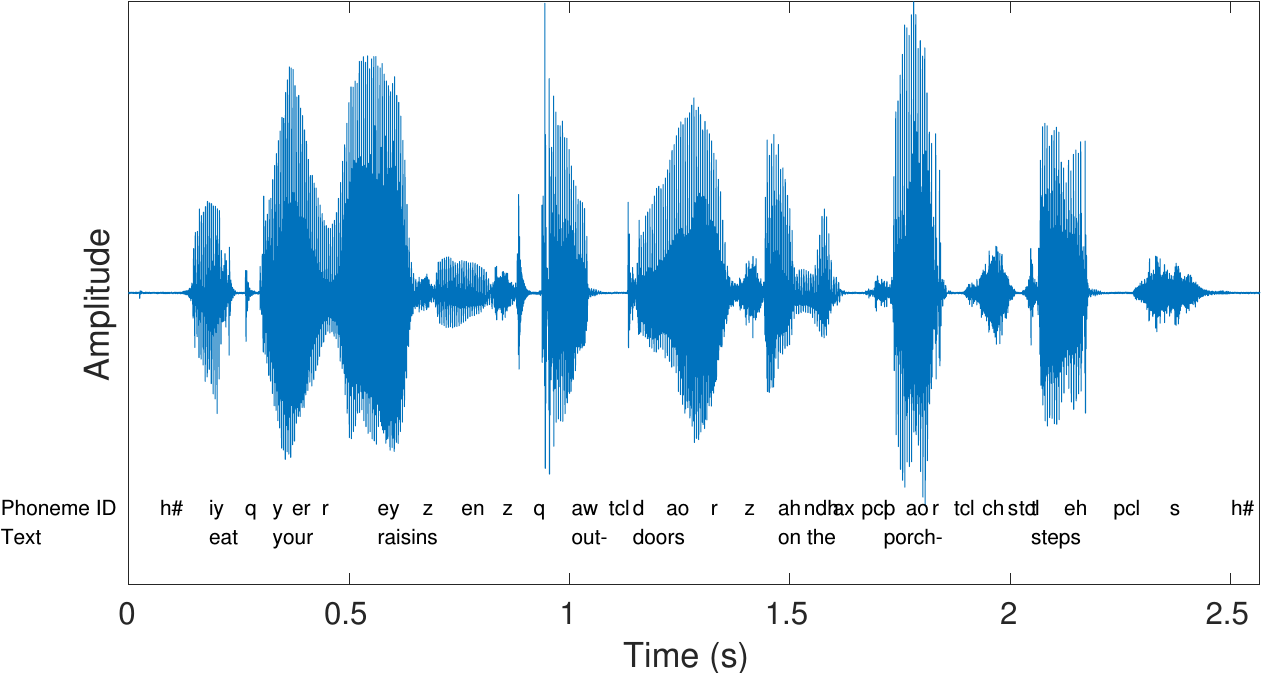

When learning with audio, it is often useful to pre-process the audio input before feeding it into the model. Why?

There are several reasons why that could be the case. Here are a few that are relevant to IDL Homeworks:
- **To learn with dense features**: The  $ T \times 1$ ends up being of very **high dimensionality**. For a 2 second utterance sampled at 16kHz, $ T = 16 \times 10^3 \times 2 = 32,000$. It is sometimes desirable to compute features from the raw audio that are more information dense than the audio itself.
- **Augmenting** the dataset to:
  - make the model more robust to challenging cases that might be expected at inference time
  - artificially expand the dataset

There are many other reasons that necessitate data preprocessing.




## Extracting Features: MFCCs
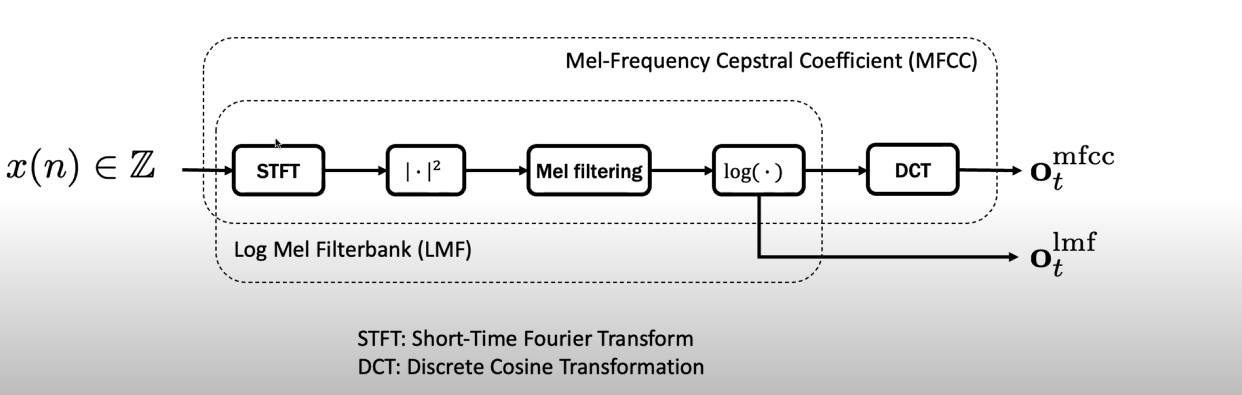

In [2]:
# data loading
import os
import numpy as np
import torch
import torchaudio
import librosa
import librosa.display
import IPython
import IPython.display
import matplotlib.pyplot as plt
import torchaudio.transforms as tat

In [6]:
def download_librispeech_samples(output_path):
    """
    Download specific samples from LibriSpeech dataset to a specified output directory
    
    Args:
        output_path (str): Directory path where audio files will be saved
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    
    # Clean up any existing .flac files in the output directory
    !rm -f {output_path}/*.flac*
    
    # Base URL for LibriSpeech samples
    base_url = "https://dagshub.com/DagsHub/Librispeech-ASR-corpus/raw/2fead768d9690a42d186188ed77a6d4c63c949dd/test-clean/8230/279154/8230-279154-000"
    
    # Download only samples 2 and 3
    for i in [1, 2]:  # Simplified range since we only want these two files
        file_url = f"{base_url}{i}.flac"
        output_file = os.path.join(output_path, f"sample_{i}.flac")
        !wget -O {output_file} {file_url}
    
    print(f"Downloaded audio files to: {output_path}")

# Example usage:
output_path = "data/audio/"
download_librispeech_samples(output_path)

--2025-04-08 11:12:58--  https://dagshub.com/DagsHub/Librispeech-ASR-corpus/raw/2fead768d9690a42d186188ed77a6d4c63c949dd/test-clean/8230/279154/8230-279154-0001.flac
Resolving dagshub.com (dagshub.com)... 35.186.200.224
Connecting to dagshub.com (dagshub.com)|35.186.200.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/audio/sample_1.flac’

data/audio/sample_1     [  <=>               ] 300.04K  1.07MB/s    in 0.3s    

2025-04-08 11:12:59 (1.07 MB/s) - ‘data/audio/sample_1.flac’ saved [307246]

--2025-04-08 11:13:00--  https://dagshub.com/DagsHub/Librispeech-ASR-corpus/raw/2fead768d9690a42d186188ed77a6d4c63c949dd/test-clean/8230/279154/8230-279154-0002.flac
Resolving dagshub.com (dagshub.com)... 35.186.200.224
Connecting to dagshub.com (dagshub.com)|35.186.200.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/audio/samp

In [12]:
audio_path = 'data/audio/sample_2.flac'

In [13]:
IPython.display.Audio(audio_path)

Waveform shape: (263600,)
Sample rate: 16000
Audio length (seconds): 16.475


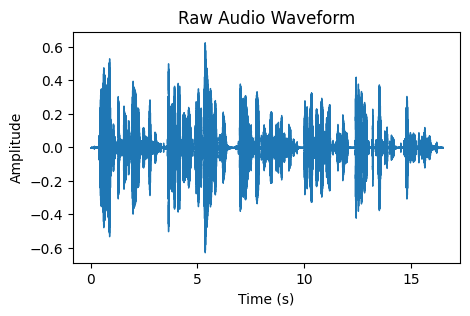

In [14]:
# Load the audio file into the and get basic info
waveform, sample_rate = librosa.load(audio_path, sr=None)  # sr=None to keep original sample rate

# Get shape and sample rate
print(f"Waveform shape: {waveform.shape}")
print(f"Sample rate: {sample_rate}")

# Get length of the audio in seconds
audio_length_seconds = len(waveform) / sample_rate
print(f"Audio length (seconds): {audio_length_seconds}")

# Visualize the raw audio waveform
plt.figure(figsize=(5, 3))
librosa.display.waveshow(waveform, sr=sample_rate)
plt.title('Raw Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

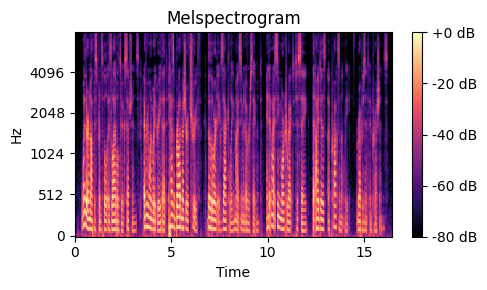

In [15]:
# Convert raw audio --> melspectrogram
S = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
S_dB = librosa.power_to_db(S, ref=np.max)

# Visualize the melspectrogram
def plot_melspectrogram(S_dB, sample_rate, title="Melspectrogram"):
    plt.figure(figsize=(5, 3))
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_melspectrogram(S_dB, sample_rate)

MFCC shape: (14, 515)


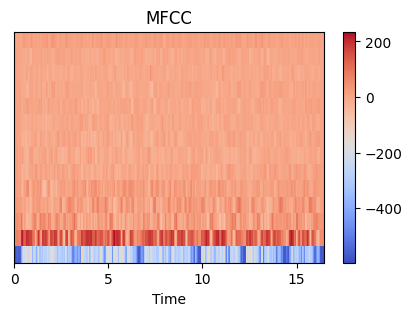

In [16]:
# Convert raw audio --> mel-frequency cepstral coefficients (MFCC)
mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=14)

# print shape
print(f"MFCC shape: {mfccs.shape}")

# Visualize the MFCC
plt.figure(figsize=(5, 3))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

## Cepstral Normalization
A process of scaling the MFCCs so that they have a mean of zero and a standard deviation of one. This standardization technique makes sure that the MFCCs are not dominated by some particular part of the spectrum and that all features contribute equally to the analysis.
This has several potential benefits:
 - reduction of noise impact
 - better robustness across environments
 - enhancement of feature discriminability

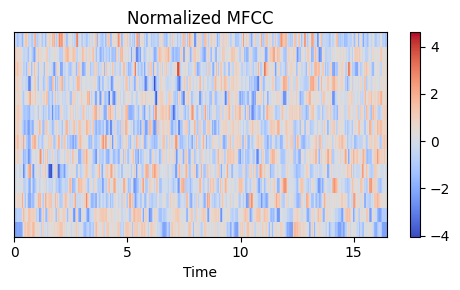

In [17]:
# Apply normalization
mfccs_normalized = (mfccs - mfccs.mean(axis=1, keepdims=True)) / (mfccs.std(axis=1, keepdims=True) + 1e-5)

# Visualize MFCCs after cepstral normalization
plt.figure(figsize=(5, 3))
librosa.display.specshow(mfccs_normalized, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('Normalized MFCC')
plt.tight_layout()
plt.show()

## Augmentations for MFCCs
These are motivated by the SpecAugment paper.
The objectives are to:
- reducing overfitting
- improve robustness to deformations in the time direction, partial loss of frequency information and partial loss of small segments of
speech

### Time masking


**Masking: involves selectively hiding or blocking parts of input or output data to allow a model to focus on specific, relevant features or areas of interest, improving accuracy and learning.**


parameters:
-  **time_mask_param**: maximum possible length of the mask. Indices uniformly sampled from  [0, time_mask_param).
- **iid_masks**: whether to apply different masks to each example/channel in the batch.
- **p**:maximum proportion of time steps that can be masked. Must be within range [0.0, 1.0]

Text(0.5, 1.0, 'Time-Masked MFCC')

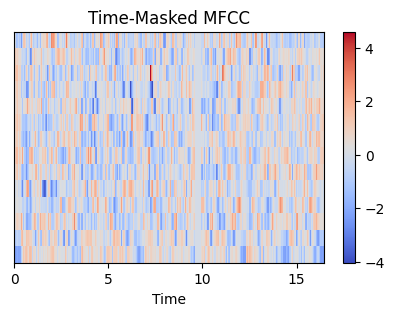

In [18]:
time_mask = tat.TimeMasking(time_mask_param=100, p=0.2)
time_masked_mfcc = time_mask(torch.tensor(mfccs_normalized))
# plot
plt.figure(figsize=(5, 3))
librosa.display.specshow(time_masked_mfcc.numpy(), sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('Time-Masked MFCC')

### Frequency masking
parameters:
-  **freq_mask_param**: maximum possible length of the mask. Indices uniformly sampled from [0, freq_mask_param).
- **iid_masks**: whether to apply different masks to each example/channel in the batch

Text(0.5, 1.0, 'Frequency-Masked MFCC')

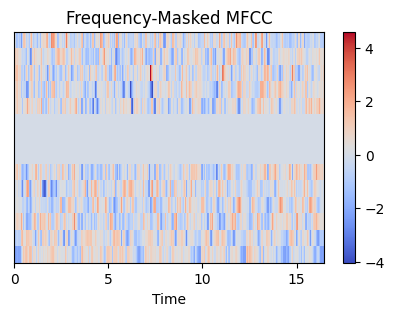

In [19]:
freq_mask = tat.FrequencyMasking(freq_mask_param=5)
freq_masked_mfcc = freq_mask(torch.tensor(mfccs_normalized))
# plot
plt.figure(figsize=(5, 3))
librosa.display.specshow(freq_masked_mfcc.numpy(), sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('Frequency-Masked MFCC')


Augmentations on a mini-batch

In [25]:
import glob
audio_files = glob.glob('data/audio/sample_*.flac')
print(audio_files)

['data/audio/sample_2.flac', 'data/audio/sample_1.flac']


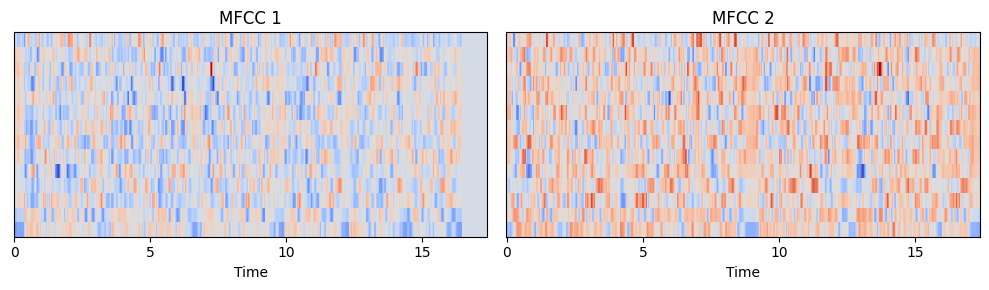

In [26]:
# load all audio files
waveforms = []
for audio_file in audio_files:
    waveform, sample_rate = librosa.load(audio_file, sr=None)
    waveforms.append(waveform)

# Compute MFCCs
mfccs_batch = []
for waveform in waveforms:
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=14)
    # normalize them
    mfcc = (mfcc - mfcc.mean(axis=1, keepdims=True)) / (mfcc.std(axis=1, keepdims=True) + 1e-5)
    mfccs_batch.append(mfcc)

# Pad MFCCs to the same length
max_length = max(mfcc.shape[1] for mfcc in mfccs_batch)
padded_mfccs_batch = [np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant') for mfcc in mfccs_batch]

# Plot as a 2 by 2 grid
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.flatten()

for i, mfcc in enumerate(padded_mfccs_batch):
    if i < 4:  # Ensure there are only 4 plots
        ax = axes[i]
        librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time', ax=ax)
        ax.set_title(f'MFCC {i+1}')

plt.tight_layout()
plt.show()

/tmp/ipykernel_179352/4145580166.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  time_masked_mfccs_batch = time_mask(torch.tensor(padded_mfccs_batch))


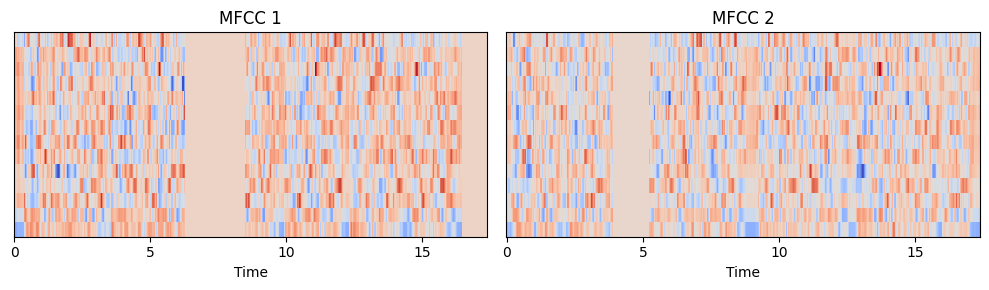

In [27]:
# time masking in a batch with IID mask = true
time_mask = tat.TimeMasking(time_mask_param=100, iid_masks=True, p=0.8)
time_masked_mfccs_batch = time_mask(torch.tensor(padded_mfccs_batch))
# plot
# Plot as a 2 by 2 grid
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.flatten()

for i, mfcc in enumerate(time_masked_mfccs_batch):
    if i < 4:  # Ensure there are only 4 plots
        ax = axes[i]
        librosa.display.specshow(mfcc.numpy(), sr=sample_rate, x_axis='time', ax=ax)
        ax.set_title(f'MFCC {i+1}')

plt.tight_layout()
plt.show()

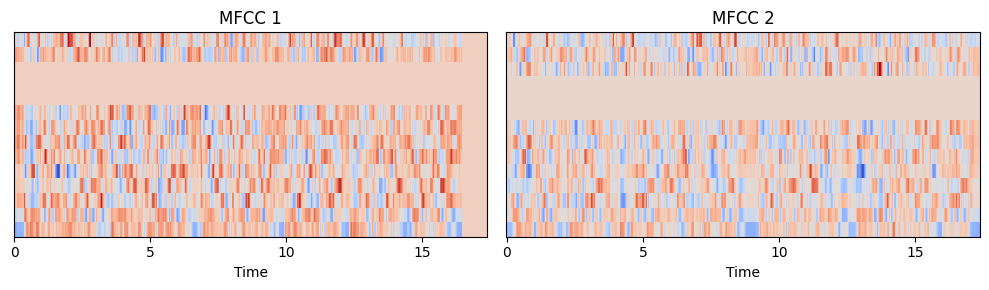

In [28]:
# frequency masking with IID = true
freq_mask = tat.FrequencyMasking(freq_mask_param=4, iid_masks=True)
freq_masked_mfccs_batch = freq_mask(torch.tensor(padded_mfccs_batch))
# plot
# Plot as a 2 by 2 grid
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.flatten()

for i, mfcc in enumerate(freq_masked_mfccs_batch):
    if i < 4:  # Ensure there are only 4 plots
        ax = axes[i]
        librosa.display.specshow(mfcc.numpy(), sr=sample_rate, x_axis='time', ax=ax)
        ax.set_title(f'MFCC {i+1}')

plt.tight_layout()
plt.show()